# 2. MNIST data

In [1]:
from tensorflow import keras
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
random.seed(10)
plt.style.use('ggplot')

Nc = 10


def loadData():
    Sets = ["Train", "Valid", "Test"]
    d = dict((s, {"X": np.array([]), "Y": np.array([]), "N": []})
             for s in Sets)

    (X, Y), (X_, Y_) = keras.datasets.mnist.load_data()
    n = len(X[0])*len(X[0][0])

    d["Train"]["X"] = X[:50000].reshape((50000, n))/255
    d["Train"]["Y"] = Y[:50000].reshape((50000, 1))
    d["Train"]["N"] = 50000

    d["Valid"]["X"] = X[50000:].reshape((10000, n))/255
    d["Valid"]["Y"] = Y[50000:].reshape((10000, 1))
    d["Valid"]["N"] = 10000

    d["Test"]["X"] = X_.reshape((10000, n))/255
    d["Test"]["Y"] = Y_.reshape((10000, 1))
    d["Test"]["N"] = 10000
    return d, n


def defClass(d):

    Class = [{"List": np.array([False] * d["N"]), "N":0, "pi":0,
              "mu": 0, "sigma": 0, "det":0} for i in range(Nc)]
    for i in range(d["N"]):
        Class[d["Y"][i][0]]["List"][i] = True

    for c in Class:
        c["N"] = sum(c["List"])
        c["pi"] = c["N"]/d["N"]
        c["mu"] = np.mean(d["X"][c["List"]], axis=0)
        c["sigma"] = np.std(d["X"][c["List"]], axis=0)
    return Class


def Probability(d, C):

    P = np.empty((d["N"], Nc))
    Pr = np.empty((d["N"])).astype(int)
    for idx, c in enumerate(C):
        P[:,idx] = np.log(c["pi"]) - np.sum(np.log(c["sigma"][c["Not0"]])) - 1/2 * np.sum(np.power((d["X"][:,c["Not0"]]-c["mu"][c["Not0"]])/c["sigma"][c["Not0"]], 2),axis=1)
    return P


def ClssificationGNB(P):
    C = np.argmax(P, axis=1)
    return C


def Accuracy(d, C):
    correct = np.sum(d["Y"].reshape((d["N"], 1)) == C.reshape((d["N"], 1)))
    return correct/d["N"]

### GNB

______
First Scenario: Training the model with hyperparameter σ₀
The Accuracy on Validation set is: 84.22% w.r.t. σ₀=0.204
                         1     2     3     4     5     6     7     8     9    10
                 π =   0.10  0.11  0.10  0.10  0.10  0.09  0.10  0.10  0.10  0.10
Number of Features =    333   164   346   319   301   331   297   275   313   273
The Accuracy on Test set is: 84.03%
______
Second Scenario: Setting the σ₀ = 0.0010
The Accuracy on Validation set is: 63.16% w.r.t. σ₀=0.001
                         1     2     3     4     5     6     7     8     9    10
                 π =   0.10  0.11  0.10  0.10  0.10  0.09  0.10  0.10  0.10  0.10
Number of Features =    557   554   600   568   576   576   553   570   550   540
The Accuracy on Test set is: 63.06%


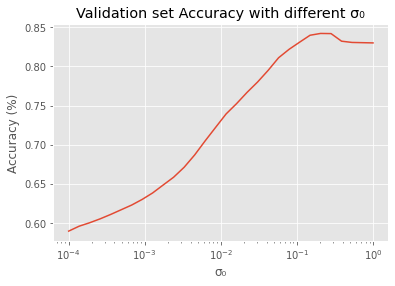

In [2]:
Sigma0 = 10**np.linspace(-4, 0, 30)
L = np.empty_like(Sigma0)
Data, n = loadData()
for s in range(len(Sigma0)):
    Class = defClass(Data["Train"])
    for c in Class:
        c["Not0"] = c["sigma"] >-1
        c["sigma"]= np.maximum(c["sigma"],Sigma0[s])
    P = Probability(Data["Valid"], Class)
    C = ClssificationGNB(P)
    L[s] = Accuracy(Data["Valid"], C)

s = np.argmax(L)
Class = defClass(Data["Train"])
for c in Class:
        c["Not0"] = c["sigma"] >-1
        c["sigma"]= np.maximum(c["sigma"],Sigma0[s])

print("_"*6+"\nFirst Scenario: Training the model with hyperparameter \u03C3₀")
print(f"The Accuracy on Validation set is: {L[s]*100:.2f}% w.r.t. \u03C3₀={Sigma0[s]:.3f}")
print(" "*20     +            str().join([f"{i  :6}"    for i  in range(1,Nc+1)]))
print(" "*17     +"\u03C0 = "+str().join([f"{pi :6.2f}" for pi in [c["pi"]                            for c in Class   ]]))
print("Number of Features = "+str().join([f"{F  :6.0f}" for F  in [sum(Class[i]["sigma"]!=Sigma0[s])  for i in range(Nc)]]))

plt.plot(Sigma0, L)
plt.title("Validation set Accuracy with different \u03C3₀")
plt.xlabel("\u03C3₀")
plt.ylabel("Accuracy (%)")
plt.xscale("log")

P = Probability(Data["Test"], Class)
C = ClssificationGNB(P)
L1 = Accuracy(Data["Test"], C)
print(f"The Accuracy on Test set is: {L1*100:.2f}%")


Sigma0 = 10**(-3)
print("_"*6+f"\nSecond Scenario: Setting the \u03C3₀ = {Sigma0:.4f}")
Class = defClass(Data["Train"])
for c in Class:
    c["Not0"] = c["sigma"] >-1
    c["sigma"]= np.maximum(c["sigma"],Sigma0)
P = Probability(Data["Valid"], Class)
C = ClssificationGNB(P)
L = Accuracy(Data["Valid"], C)

print(f"The Accuracy on Validation set is: {L*100:.2f}% w.r.t. \u03C3₀={Sigma0:.3f}")
print(" "*20     +            str().join([f"{i  :6}"    for i  in range(1,Nc+1)]))
print(" "*17     +"\u03C0 = "+str().join([f"{pi :6.2f}" for pi in [c["pi"]                            for c in Class   ]]))
print("Number of Features = "+str().join([f"{F  :6.0f}" for F  in [sum(Class[i]["sigma"]!=Sigma0)  for i in range(Nc)]]))
P = Probability(Data["Test"], Class)
C = ClssificationGNB(P)
L1 = Accuracy(Data["Test"], C)
print(f"The Accuracy on Test set is: {L1*100:.2f}%")


### kNN - GPU Parallelized Computing with CUDA 

In [3]:
import time
try:
    from numba import jit, prange, objmode
except:
    !pip3 install numba
    from numba import jit, prange, objmode


@jit(nopython=True, fastmath=True, parallel=True)
def calculateDistances(X1, X2):
    N1 = len(X1)
    N2 = len(X2)
    n = X1.shape[1]
    Distances = np.zeros((N2, N1))
    for i2 in range(N2):
        for i1 in prange(N1):
            d_2 = 0
            for n_ in range(n):
                minus = X1[i1, n_] - X2[i2, n_]
                d_2 += minus * minus
            Distances[i2, i1] = d_2
        with objmode():
            if (i2-3) % 7 == 0:
                Time = int((time.time()-Start)*(N2-i2-1)/(i2+1))
                (M, S) = divmod(Time, 60)
                gear = [["•"], [" "], ["o"], ["\\"], ["|"], [
                    "/"], ["—"], ["o"], [" "]][int(i2/10) % 9][0]
                Progress = (i2+1)/N2*100
                print(' {} Progress: {:.2f}% , ({}/{}), Expected Remaining time: {:0>2}:{:0>2} {}'.format(
                    gear, Progress, i2+1, N2, M, S, gear), end='\r')
    print("")
    return Distances


def kNNfinder(d1, d2, nk=200):
    NN = np.empty((d2["N"], nk), dtype=np.int32)
    distances = calculateDistances(d1["X"], d2["X"])
    print(f"Distances Calculated in {time.time()-Start:.2f} seconds.")
    for i in range(d2["N"]):

        NN[i, :] = d1["Y"][np.argsort(distances[i])[
            :nk].astype(int)].reshape((1, nk))
    print("kNN is ready!\n")
    return NN


def TrainK(d, kNN, kVec):

    Sum = np.zeros((d["N"], 10))
    for i in range(d["N"]):
        V, C = np.unique(kNN[i, :kVec[0]], return_counts=True)

        for j in range(len(V)):
            Sum[i, V[j]] = C[j]

    Accu = []
    for k in kVec:
        C = np.argmax(Sum, axis=1)
        Accu.append((k, Accuracy(d, C)))
        try:
            for i in range(d["N"]):
                Sum[i][kNN[i, k]] = Sum[i, kNN[i, k]] + 1
        except:
            return Accu


def plotAccuracy(Accu):
    plt.plot(*zip(*Accu), label="Accuracy")
    plt.title("Accuracy w.r.t. number of neighbors")
    plt.axis()
    plt.xlabel("k")
    plt.ylabel("Accuracy (%)")


def printResult(Accu, nk):
    if nk > 20:
        Show = np.sort(random.permutation(nk)[:20])
        print("Randomly chosen result:")
    else:
        Show = range(nk)
        print(f"Result for k 1 to {nk}:")

    (K, AccuM) = max(Accu, key=lambda x: x[1])
    print("        k :" +
          str().join([f"  {k:3}   " for k in [Accu[i][0] for i in Show]]))
    print(" Accuracy :" +
          str().join([f" {a*100:2.2f}% " for a in [Accu[i][1] for i in Show]]) + "\n")
    print(
        f"Best Accuracy on Validation set is {AccuM*100:.2f}% w.r.t. {K} Neighbors.")

### 2.a

 • Progress: 100.00% , (10000/10000), Expected Remaining time: 00:00 •
Distances Calculated in 186.07 seconds.
kNN is ready!

Randomly chosen result:
        k :    3       6      11      20      21      53      56      60      64      70      76      79      99     110     112     125     143     163     186     199   
 Accuracy : 97.20%  97.10%  96.92%  96.41%  96.49%  95.20%  95.11%  95.05%  95.01%  94.92%  94.76%  94.75%  94.47%  94.25%  94.22%  93.99%  93.78%  93.52%  93.31%  93.10% 

Best Accuracy on Validation set is 97.26% w.r.t. 4 Neighbors.


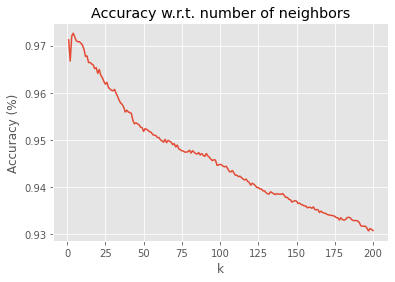

In [4]:
nk = 200
Data, n = loadData()
Start = time.time()
kNN = kNNfinder(Data["Train"], Data["Valid"])
Accu = TrainK(Data["Valid"], kNN, range(1, nk+1))
(K, AccuM) = max(Accu, key=lambda x: x[1])
plotAccuracy(Accu)
printResult(Accu, nk)

### 2.b

In [5]:
Start = time.time()
kNN = kNNfinder(Data["Train"], Data["Test"], K)
Accu = TrainK(Data["Test"], kNN, [K])
(K, AccuM) = max(Accu, key=lambda x: x[1])
print(f"Accuracy for Test Set is {AccuM*100:.2f}% w.r.t. {K} Neighbors.")

 • Progress: 100.00% , (10000/10000), Expected Remaining time: 00:00 •
Distances Calculated in 169.40 seconds.
kNN is ready!

Accuracy for Test Set is 96.58% w.r.t. 4 Neighbors.
